In [200]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


# define els_obs as an object containing x_normals and y_normals with same as size as n_pts
class els_normals:
    def __init__(self, els, n):
        n_els = len(els.x1)
        self.x = np.zeros(n_els * n)
        self.y = np.zeros(n_els * n)
        self.x_shears = np.zeros(n_els * n)
        self.y_shears = np.zeros(n_els * n)
        self.x_normals = np.zeros(n_els * n)
        self.y_normals = np.zeros(n_els * n)
        self.lengths = np.zeros(n_els * n)

        for i in range(n_els):
            xvec = np.linspace(els.x1[i], els.x2[i], n + 1)
            yvec = np.linspace(els.y1[i], els.y2[i], n + 1)
            self.x[i * n : (i + 1) * n] = 0.5 * (xvec[1:] + xvec[0:-1])
            self.y[i * n : (i + 1) * n] = 0.5 * (yvec[1:] + yvec[0:-1])
            self.x_shears[i * n : (i + 1) * n] = els.x_shears[i]
            self.y_shears[i * n : (i + 1) * n] = els.y_shears[i]
            self.x_normals[i * n : (i + 1) * n] = els.x_normals[i]
            self.y_normals[i * n : (i + 1) * n] = els.y_normals[i]
            self.lengths[i * n : (i + 1) * n] = els.lengths[i] / n


def extract_quadratic_components(quadratic_coefs, n_els):
    # extract (s,n) components and store them in 2 separate vectors
    quadratic_coefs_s = np.zeros((3 * n_els, 1))
    quadratic_coefs_n = np.zeros((3 * n_els, 1))
    for i in range(n_els):
        quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
        quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[
            6 * i + 3 : 6 * (i + 1)
        ]

    return quadratic_coefs_s, quadratic_coefs_n

# Construct fault populations

In [201]:
def fault_population(nfaults, L_exp, Lmin, Lmax, z_exp, zmin, zmax, xmin, xmax, ngrid, box_minx, box_maxx):
    x1 = np.array([])
    x2 = np.array([])
    y1 = np.array([])
    y2 = np.array([])
    original_shapes = []

    uniform_samples = np.random.rand(nfaults) # to randomly sample from power-law 
    L_population = ((Lmax**(L_exp + 1) - Lmin**(L_exp + 1)) * uniform_samples + Lmin**(L_exp + 1)) ** (1 / (L_exp + 1))
    uniform_samples = np.random.rand(nfaults) # to randomly sample from power-law 
    fault_centroidsz = ((zmax**(z_exp + 1) - zmin**(z_exp + 1)) * uniform_samples + zmin**(z_exp + 1)) ** (1 / (z_exp + 1))    

    positive_or_negative = np.random.choice([-1, 1], size=len(fault_centroidsz))
    fault_centroidsz = fault_centroidsz * positive_or_negative

    for fault in range(nfaults):
        xcenter = np.random.uniform(xmin, xmax)
        xmini = xcenter - (L_population[fault] / 2)
        xmaxi = xcenter + (L_population[fault] / 2)
        x = np.linspace(xmini, xmaxi, round(L_population[fault]))
        
        # deal with faults that may extend beyond the box boundaries
        if min(x)<box_minx:
            x = x-box_minx # recall box_minx is negative
        elif max(x)>box_maxx:
            x = x-box_maxx

        z = np.repeat(fault_centroidsz[fault],len(x))
        x1_across = x[0:-1]
        x2_across = x[1:]
        y1_across = z[0:-1]
        y2_across = z[1:]

        x1 = np.concatenate([x1, x1_across])
        x2 = np.concatenate([x2, x2_across])
        y1 = np.concatenate([y1, y1_across])
        y2 = np.concatenate([y2, y2_across])
        original_shapes.append(x1_across.shape) # for finding displacements attributed to individual cracks later
    
    return x1, x2, y1, y2, original_shapes, L_population, fault_centroidsz


# Construct a fault inside an arbitrary sized box domain

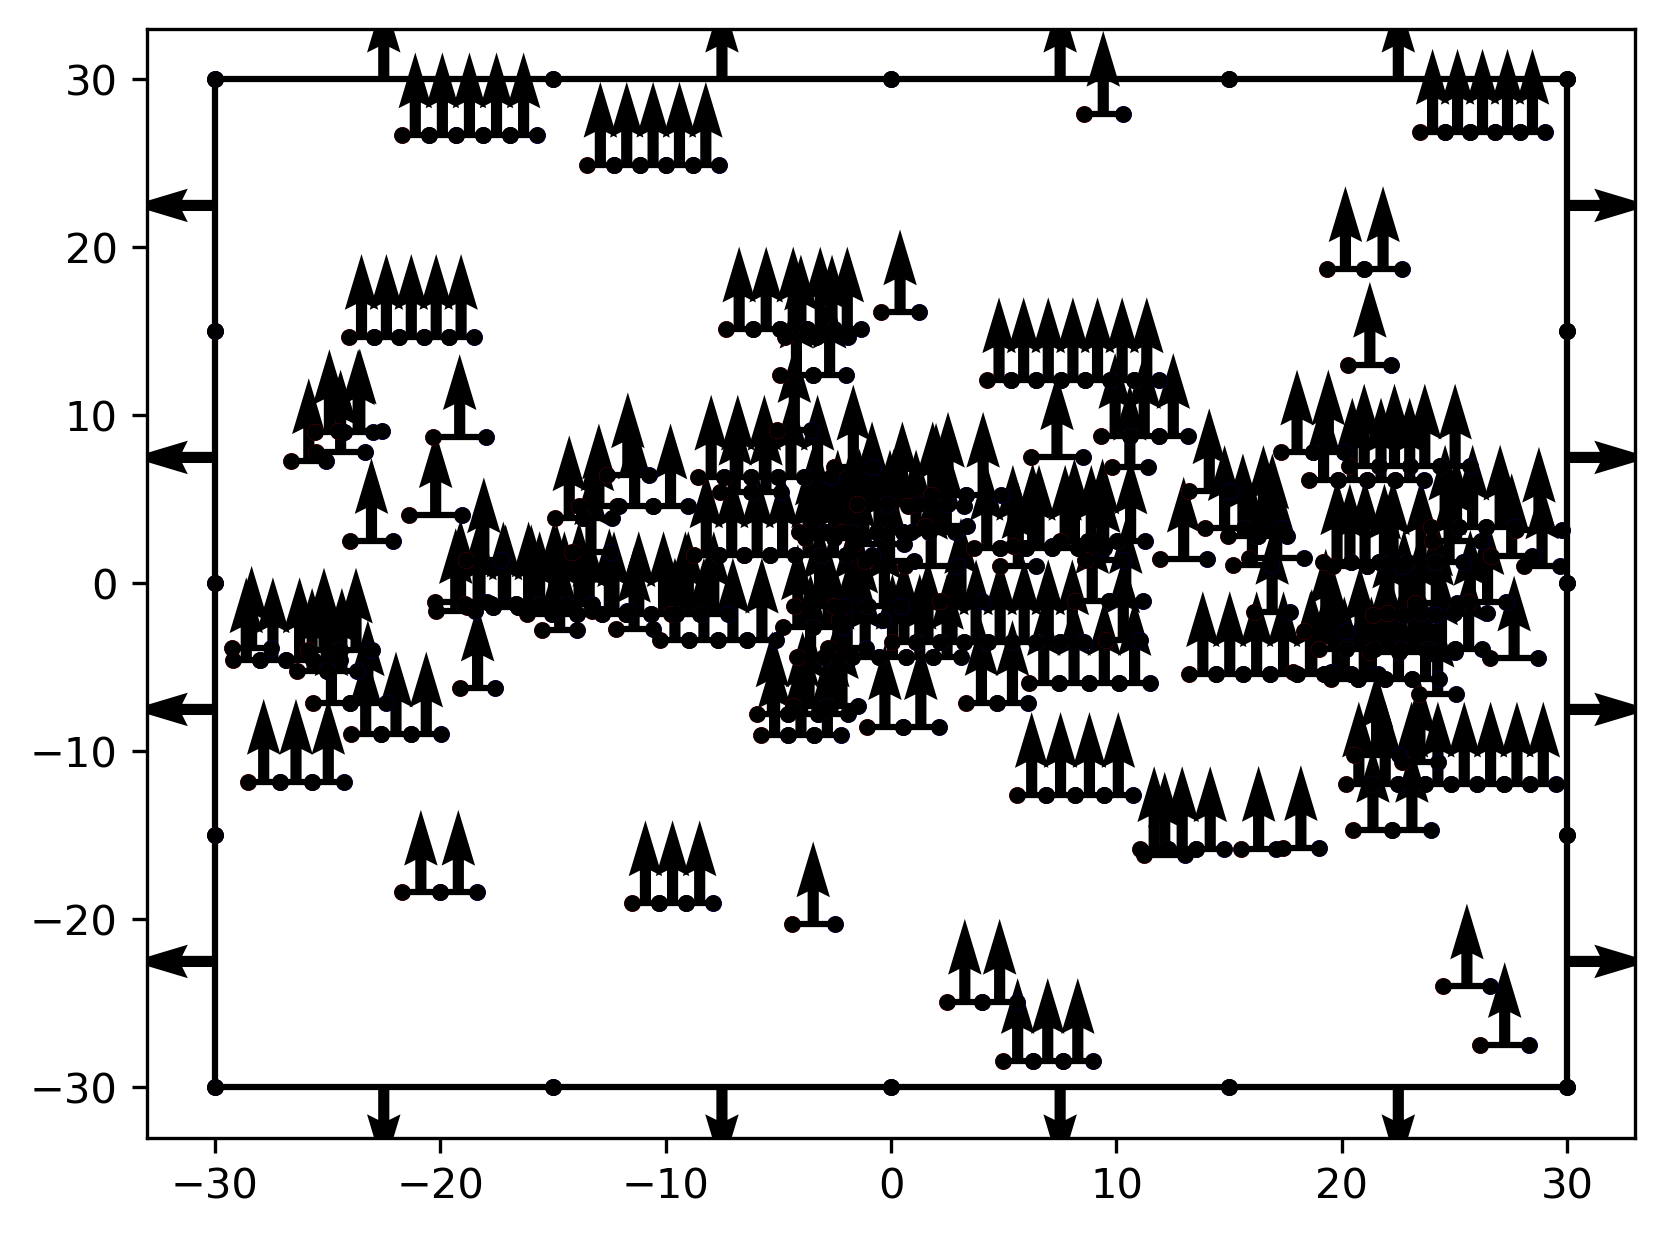

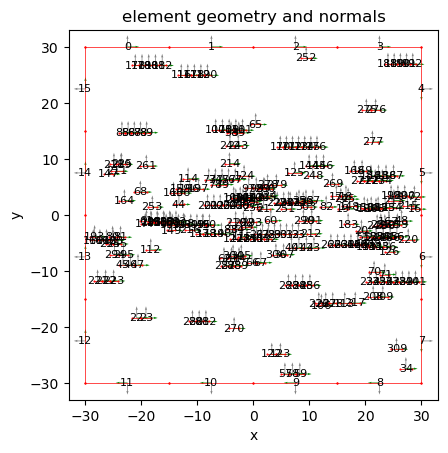

In [202]:
# Create a box mesh with a sinusoidal fault in the middle
L = 30.0
H = L * 1.0
ngrid = 2
corners = np.array([[-L, H], [L, H], [L, -H], [-L, -H], [-L, H]])
np.random.seed(40)

# Create arrays of the x and y coordinates of the corners
x, z = [], []
for i in range(4):
    lsegment = np.sqrt(
        (corners[i, 0] - corners[(i + 1), 0]) ** 2
        + (corners[i, 1] - corners[(i + 1), 1]) ** 2
    )
    xi = np.linspace(
        corners[i][0],
        corners[(i + 1) % 4][0],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    zi = np.linspace(
        corners[i][1],
        corners[(i + 1) % 4][1],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    x.append(xi)
    z.append(zi)
    
x.append(corners[0, 0])
z.append(corners[0, 1])
x = np.hstack(x)
z = np.hstack(z)

x1_box = x[0:-1]
x2_box = x[1:]
y1_box = z[0:-1]
y2_box = z[1:]

# Elastic parameters
mu = 1
nu = 0.25

# fault_population(nfaults, L_exp, Lmin, Lmax, z_exp, zmin, zmax, xmin, xmax, ngrid, box_minx, box_maxx)
x1,x2,y1,y2,original_shapes,L_population,fault_centroidsz = fault_population(200, -2, 1, 10, -1.1, 1, 29, -30, 30, ngrid,min(x1_box),max(x2_box))

els = bemcs.initialize_els()
els.x1 = np.concatenate([x1_box, x1])
els.y1 = np.concatenate([y1_box, y1])
els.x2 = np.concatenate([x2_box, x2])
els.y2 = np.concatenate([y2_box, y2])
bemcs.standardize_els_geometry(els, reorder=False)

plt.figure(dpi=300)
plt.plot(els.x1, els.y1, "r.")
plt.plot(els.x2, els.y2, "b.")
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
    plt.quiver(els.x_centers[i],els.y_centers[i],els.x_normals[i],els.y_normals[i])

# plt.xlim(-10,20)
# plt.ylim(-1,10)
plt.show()

bemcs.plot_els_geometry(els)


# Imposed tractions as BC (specified in $x,y$ direction)

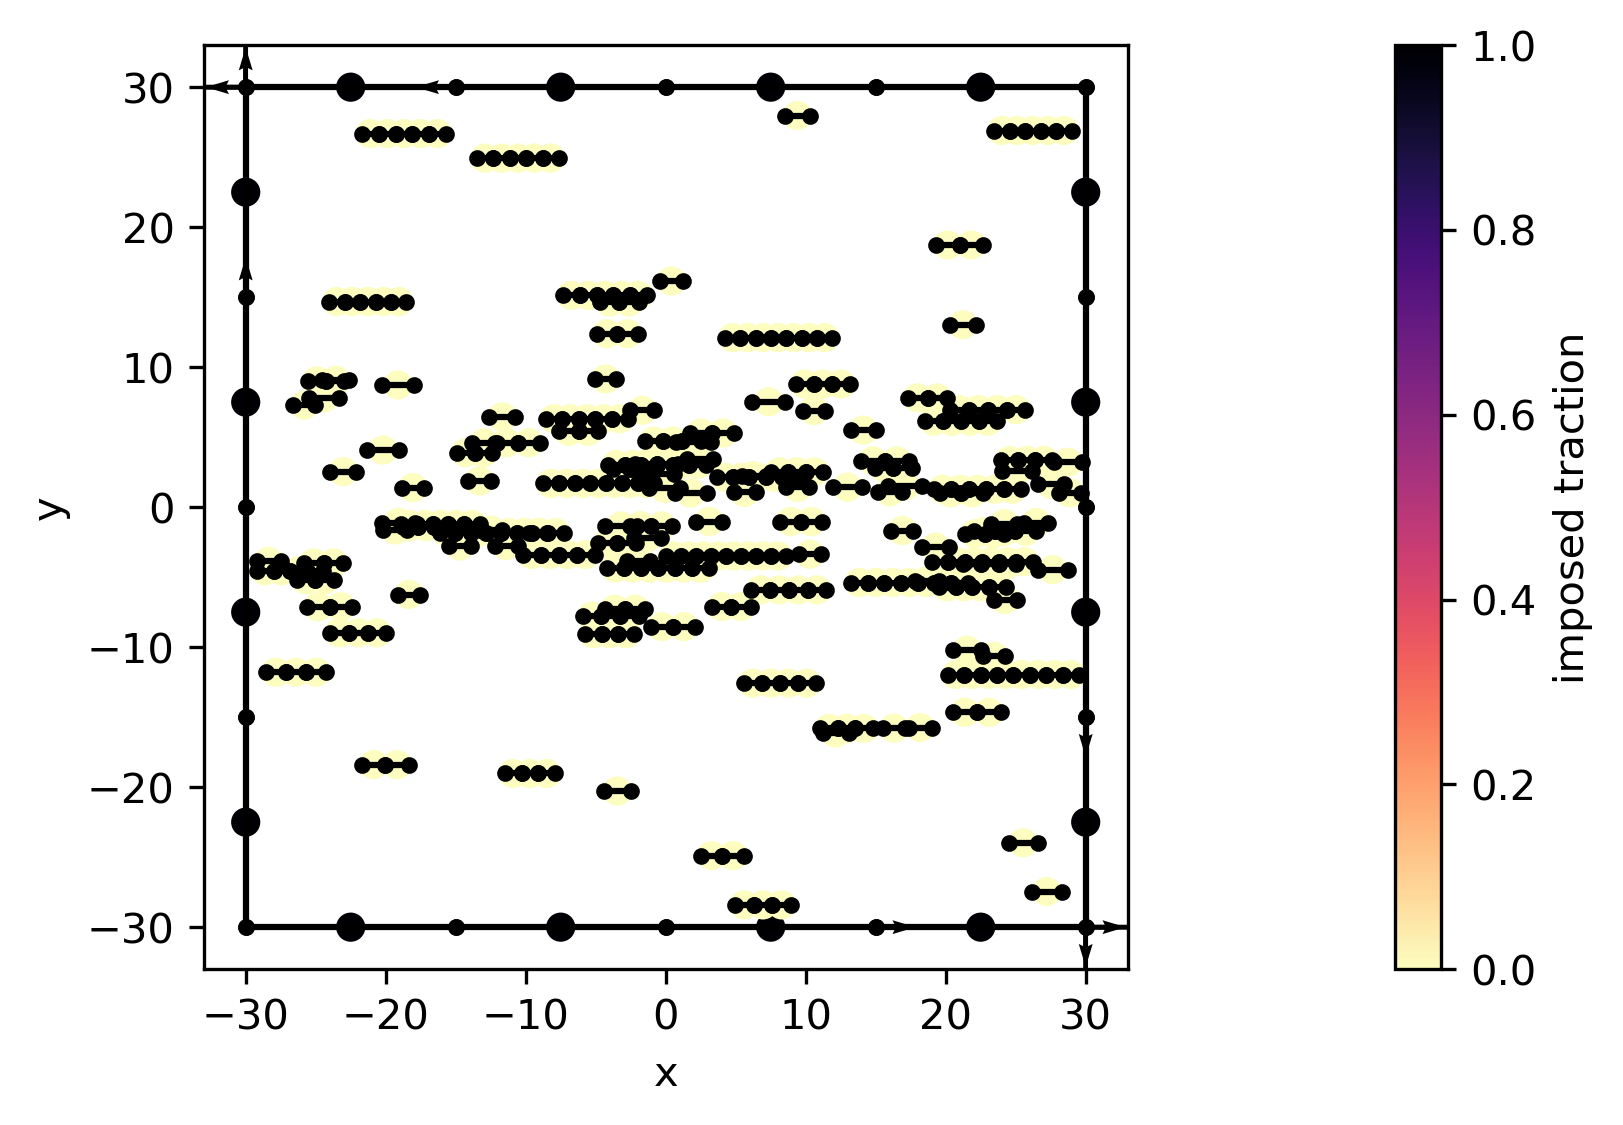

In [203]:
# Global stress tensor
sigma_xx = 0
sigma_yy = -sigma_xx
sigma_xy = -1

# Traction imposed at central nodes of each patch (these are in x,y coordinates)
traction_vector_x = np.hstack(
    [
        sigma_xx * els.x_normals[0 : len(x1_box)]
        + sigma_xy * els.y_normals[0 : len(x1_box)],
        np.zeros_like(x1),
    ]
)
traction_vector_y = np.hstack(
    [
        sigma_xy * els.x_normals[0 : len(x1_box)]
        + sigma_yy * els.y_normals[0 : len(x1_box)],
        np.zeros_like(x1),
    ]
)

plt.figure(figsize=(23, 4),dpi=300)
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")

plt.scatter(
    els.x_centers,
    els.y_centers,
    c=np.sqrt(traction_vector_x**2 + traction_vector_y**2),
    marker="o",
    cmap="magma_r",
)
plt.colorbar(label="imposed traction")
plt.quiver(
    els.x_centers, els.y_centers, traction_vector_x, traction_vector_y, width=0.005
)
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# BEMCS labels nodes and calculates kernels

In [204]:
index_open, index_overlap, index_triple = bemcs.label_nodes(els)
n_els = len(els.x1)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# apply BCs at central nodes
BC_c[0::2, 0] = traction_vector_x
BC_c[1::2, 0] = traction_vector_y

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, reference="local"
)

# Patch center locations
obs_xy = np.vstack((els.x_centers, els.y_centers)).T
x_obs = obs_xy[:, 0].reshape(-1, 1)
y_obs = obs_xy[:, 1].reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="global")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="global")

Number of open nodes = 254
: [array([579]), array([480]), array([663]), array([581]), array([441]), array([762]), array([240]), array([882]), array([654]), array([633]), array([443]), array([675]), array([491]), array([671]), array([255]), array([492]), array([135]), array([767]), array([635]), array([245]), array([659]), array([677]), array([887]), array([494]), array([534]), array([66]), array([204]), array([783]), array([183]), array([531]), array([143]), array([336]), array([206]), array([894]), array([759]), array([465]), array([269]), array([533]), array([71]), array([785]), array([185]), array([338]), array([761]), array([270]), array([548]), array([447]), array([495]), array([476]), array([132]), array([449]), array([477]), array([348]), array([924]), array([908]), array([342]), array([134]), array([500]), array([648]), array([588]), array([479]), array([926]), array([840]), array([344]), array([650]), array([411]), array([147]), array([593]), array([603]), array([219]), array(

/Users/adminalba/Documents/BEM_code/bemcs/bemcs/bemcs.py:150: RuntimeWarning: divide by zero encountered in divide
  arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))
/Users/adminalba/Documents/BEM_code/bemcs/bemcs/bemcs.py:149: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))


# Assemble the design matrix and boundary conditions

In [205]:
# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))

matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

# all kernels are global traction kernels only
for k in range(0, 3):
    kerneleval_x[:, k::6] = traction_kernels_s[0][:, k::3]
    kerneleval_x[:, k + 3 :: 6] = traction_kernels_n[0][:, k::3]
    kerneleval_y[:, k::6] = traction_kernels_s[1][:, k::3]
    kerneleval_y[:, k + 3 :: 6] = traction_kernels_n[1][:, k::3]

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.pinv(matrix_system) @ BCvector
# quadratic_coefs = np.linalg.lstsq(matrix_system, BCvector)[0]
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))
dummy = matrix_system @ quadratic_coefs

# evaluate slip and traction on finer mesh
# create finely discretized observation points on els
n_eval = 4
els_obs = els_normals(els, n_eval)
_, _, sx, sy = bemcs.get_slipvector_on_fault(els, quadratic_coefs.flatten(), n_eval)

Linear Operator Condition Number: 3.2059378629604844e+16


# Plot displacements and stresses

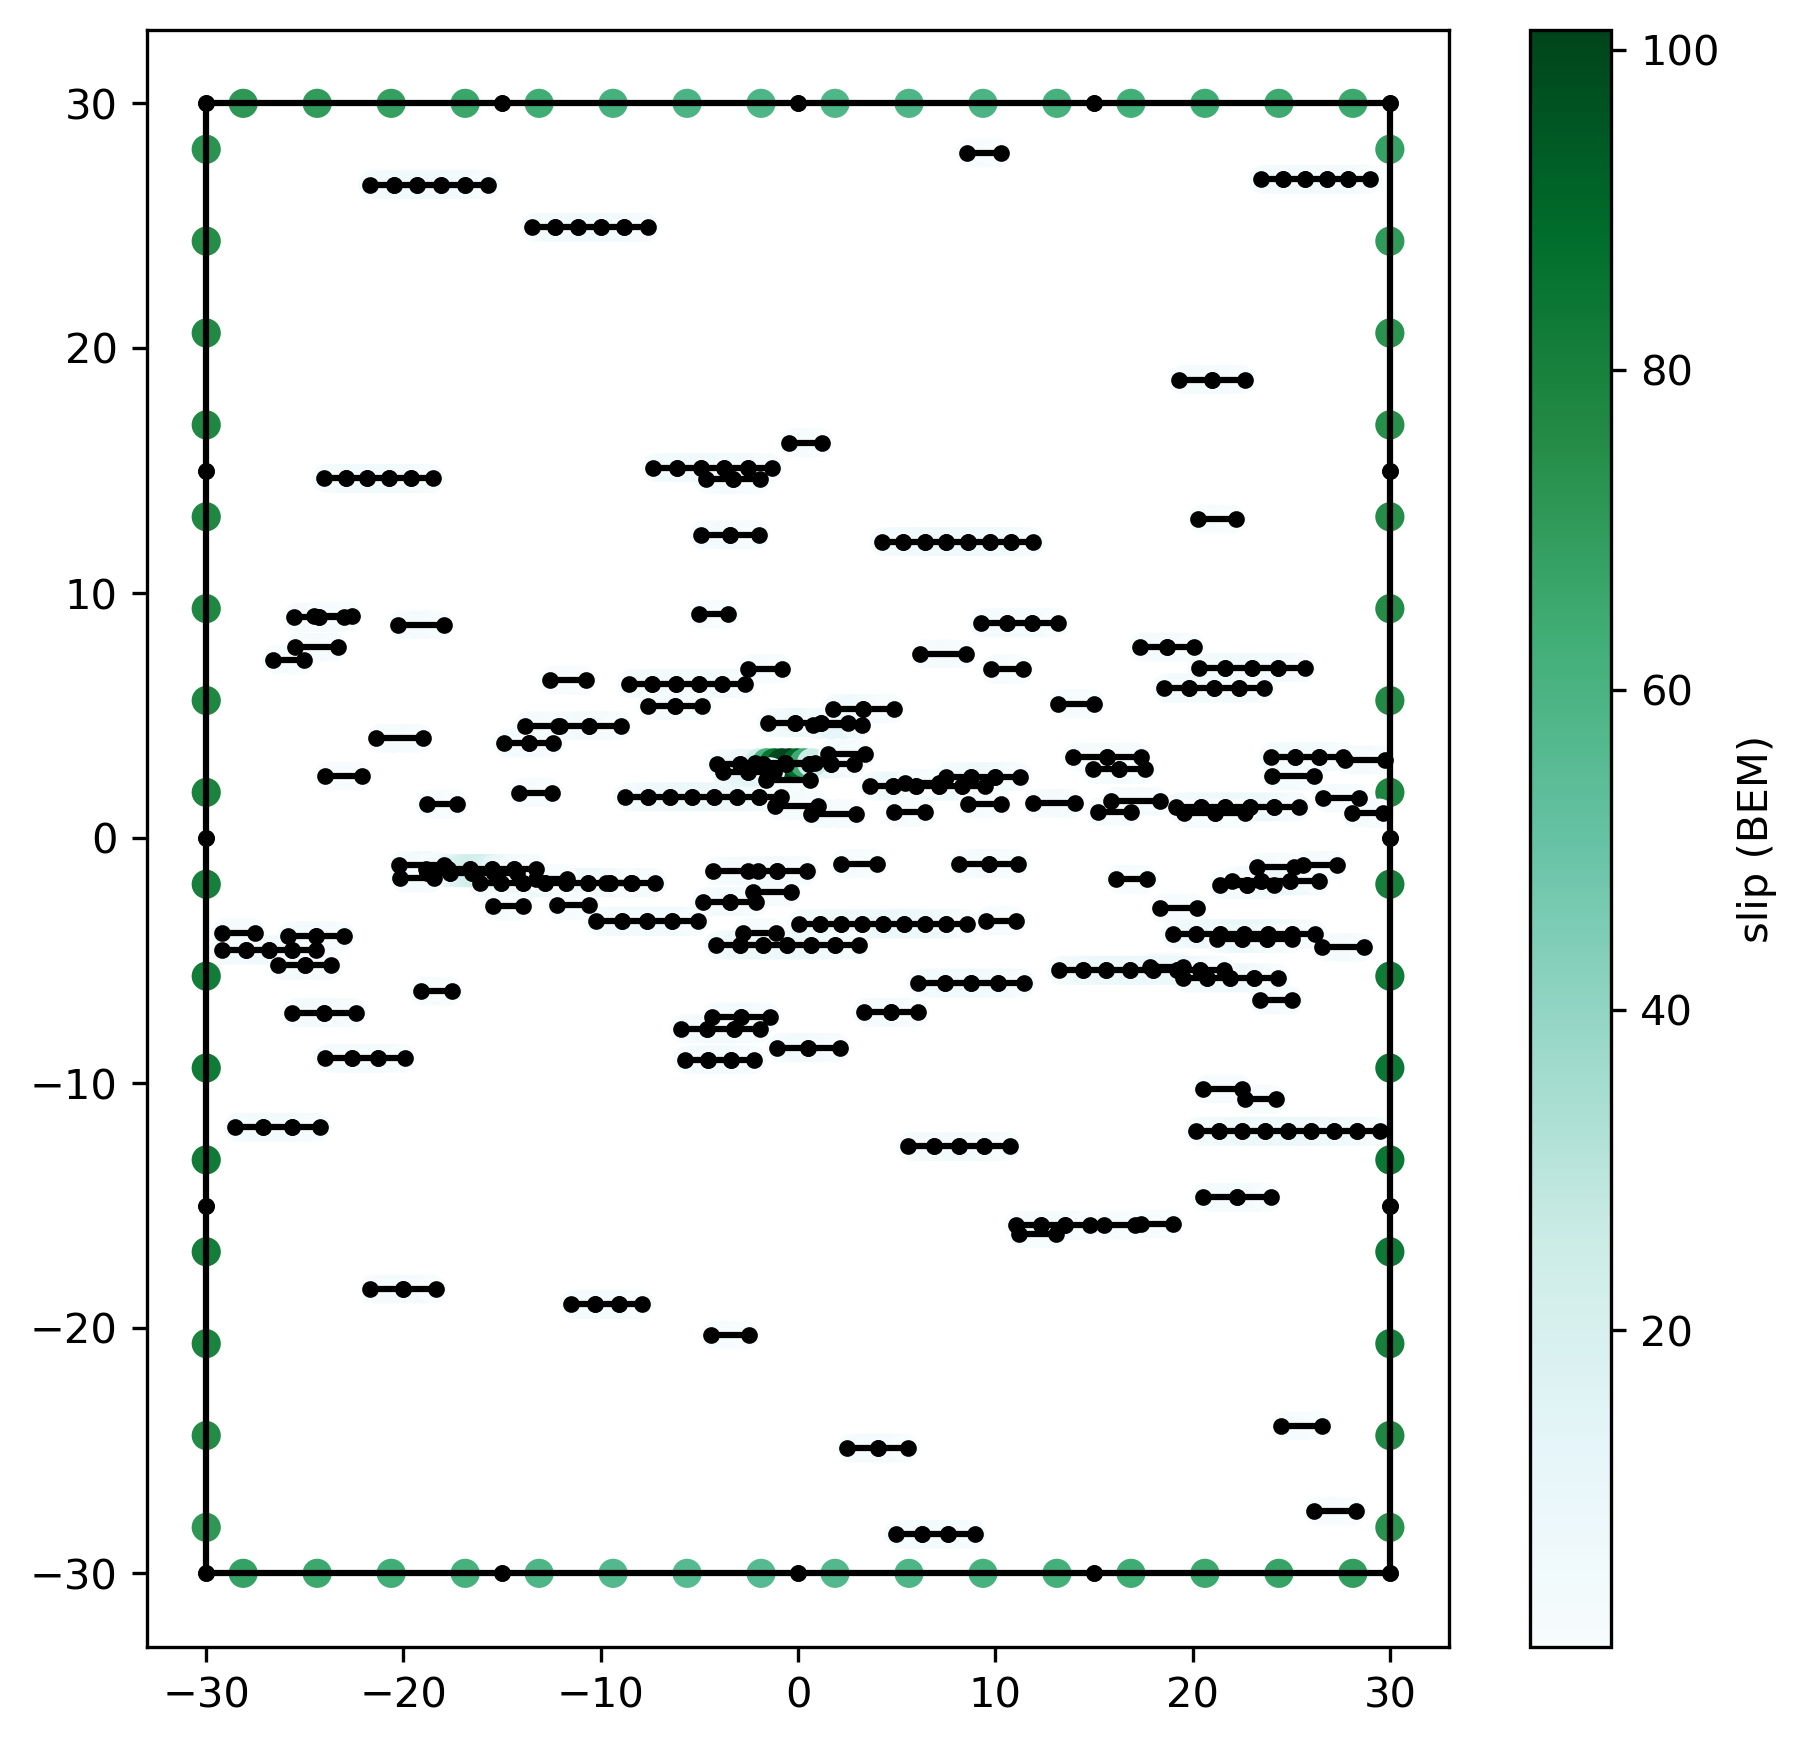

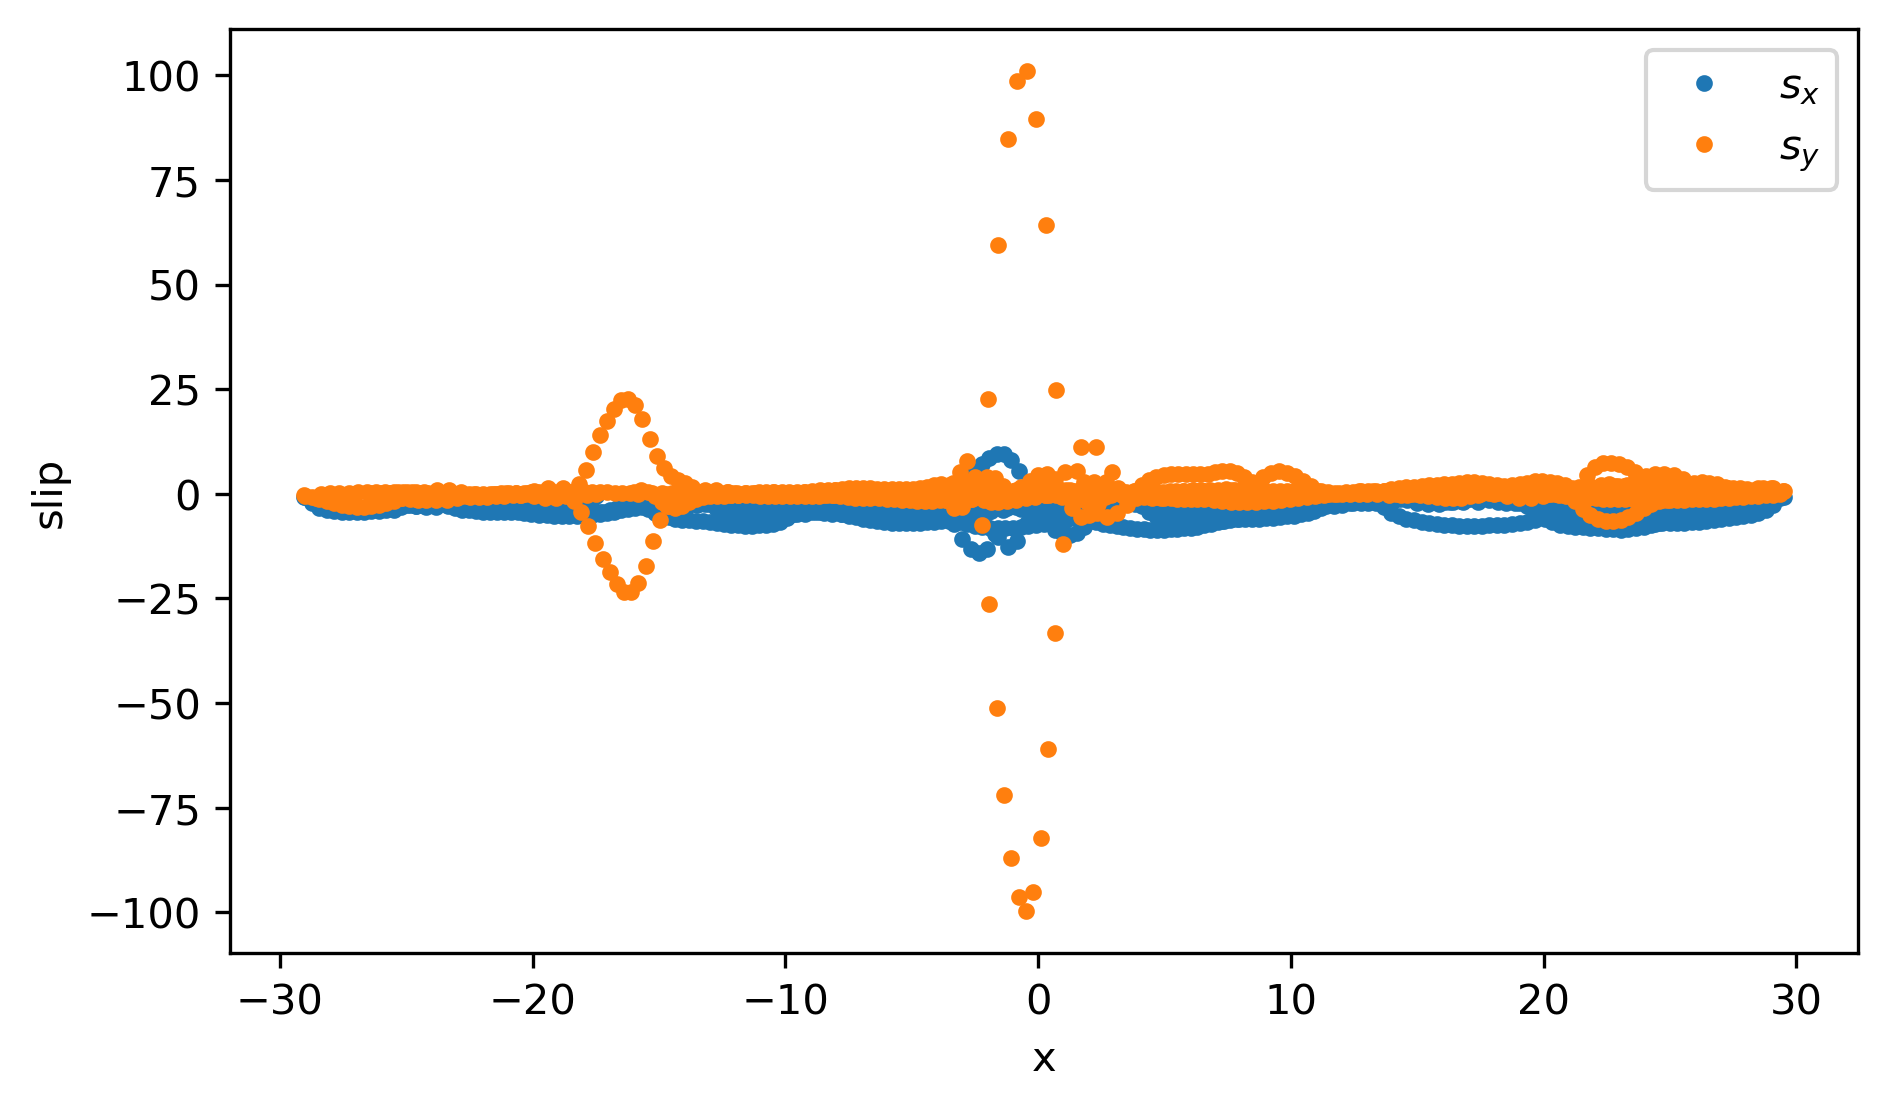

In [206]:
faultindex = np.arange((n_els - len(x1)) * n_eval, n_els * n_eval)

plt.figure(figsize=(7, 7),dpi=300)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.scatter(
    els_obs.x,
    els_obs.y,
    c=np.sqrt(sx**2 + sy**2),
    marker="o",
    cmap="BuGn",
)
plt.colorbar(label="slip (BEM)")
# plt.quiver(
#     els_obs.x[faultindex],
#     els_obs.y[faultindex],
#     sx[faultindex],
#     sy[faultindex],
#     width=0.005,
# )
# plt.xlabel("x")
# plt.ylabel("y")
# # plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# plot fault slip
plt.figure(figsize=(7, 4),dpi=300)
plt.plot(els_obs.x[faultindex], sx[faultindex], ".", label="$s_x$")
plt.plot(els_obs.x[faultindex], sy[faultindex], ".", label="$s_y$")
plt.xlabel("x")
plt.ylabel("slip")
plt.legend()
plt.show()


# Analyze displacement length relationship

In [207]:
sxfaults = sx[faultindex]
syfaults = sy[faultindex]
nfaults = 200
#  L_population, fault_centroidsz
# original_shapes

for i in range(nfaults):
    original_shapesi = original_shapes[i]
    